In [ ]:
#SVD example 
# https://antoinevastel.com/machine%20learning/python/2016/02/14/svd-recommender-system.html

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')


In [2]:
review_data = getDF('data/reviews_Video_Games.json.gz')
product_data = getDF('data/meta_Video_Games.json.gz')

# cast as 32 float to save space
review_data['overall'] = review_data['overall'].astype('float32')
product_data['price'] = product_data['price'].astype('float32')

In [3]:
prod_list = product_data.asin.unique()
rated_prod_list = review_data.asin.unique()
user_list = review_data.reviewerID.unique()
                 
print('item_count: {}, rated_item_count: {}, user_count: {}'.format(len(prod_list), len(rated_prod_list), len(user_list)))

item_count: 50953, rated_item_count: 50210, user_count: 826767


In [4]:
# We won't be able to index items through their ID since we would get memory indexing errors. 
# To amend we can create a column that shows the spot in our list that particular movie is in:

product_data['prod_index'] = product_data.index
product_data.head()

,asin,description,price,imUrl,related,salesRank,categories,title,brand,prod_index
0,0078764343,Brand new sealed!,37.98,http://ecx.images-amazon.com/images/I/513h6dPb...,"{'also_bought': ['B000TI836G', 'B003Q53VZC', '...",{'Video Games': 28655},"[[Video Games, Xbox 360, Games]]",NaN,NaN,0
1,043933702X,In Stock NOW. Eligible for FREE Super Saving ...,23.50,http://ecx.images-amazon.com/images/I/61KKRndV...,"{'also_viewed': ['B000067NP1', '0439573947', '...",{'Video Games': 44080},"[[Video Games, PC, Games]]",NaN,NaN,1
2,0439339987,Grandma Groupers kelp seeds are missing and wi...,8.95,http://ecx.images-amazon.com/images/I/416QZg89...,"{'also_bought': ['B000314VVU', 'B000PXUOTE', '...",{'Video Games': 49836},"[[Video Games, PC, Games]]",NaN,NaN,2
3,0439342260,This software is BRAND NEW. Packaging may diff...,NaN,http://ecx.images-amazon.com/images/I/61Wvu-Uj...,{'also_viewed': ['043934302X']},{'Video Games': 49156},"[[Video Games, PC, Games]]",NaN,NaN,3
4,0439339960,a scholastic clubs fairs cd rom game,NaN,http://ecx.images-amazon.com/images/I/51k3oRCF...,{'also_viewed': ['B00028D7TG']},{'Video Games': 52262},"[[Video Games, PC, Games]]",NaN,NaN,4


In [8]:
# drop some columns to save RAM
#product_data.drop(['imUrl', 'related', 'salesRank'], axis=1)
del product_data['imUrl']
del product_data['related']
del product_data['salesRank']
product_data.head()

,asin,description,price,categories,title,brand,prod_index
0,0078764343,Brand new sealed!,37.98,"[[Video Games, Xbox 360, Games]]",NaN,NaN,0
1,043933702X,In Stock NOW. Eligible for FREE Super Saving ...,23.50,"[[Video Games, PC, Games]]",NaN,NaN,1
2,0439339987,Grandma Groupers kelp seeds are missing and wi...,8.95,"[[Video Games, PC, Games]]",NaN,NaN,2
3,0439342260,This software is BRAND NEW. Packaging may diff...,NaN,"[[Video Games, PC, Games]]",NaN,NaN,3
4,0439339960,a scholastic clubs fairs cd rom game,NaN,"[[Video Games, PC, Games]]",NaN,NaN,4


In [10]:
review_data.head(1)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AB9S9279OZ3QO,0078764343,Alan,"[1, 1]",I haven't gotten around to playing the campaig...,5.0,Good game and Beta access!!,1373155200,"07 7, 2013"


In [11]:
product_data.head(1)

,asin,description,price,categories,title,brand,prod_index
0,0078764343,Brand new sealed!,37.98,"[[Video Games, Xbox 360, Games]]",NaN,NaN,0


In [12]:
data_combined = pd.merge(review_data[['reviewerID', 'asin', 'overall']], product_data[['asin', 'prod_index']], on='asin')
data_combined.head()

,reviewerID,asin,overall,prod_index
0,AB9S9279OZ3QO,0078764343,5.0,0
1,A24SSUT5CSW8BH,0078764343,5.0,0
2,AK3V0HEBJMQ7J,0078764343,4.0,0
3,A10BECPH7W8HM7,043933702X,5.0,1
4,A2PRV9OULX1TWP,043933702X,5.0,1


In [14]:
data_grouped = data_combined.groupby('reviewerID')
data_grouped.first().head()

,asin,overall,prod_index
reviewerID,,,
A00010181745VTMHSO9TO,B004RMK57U,5.0,37467
A0001920MO27X22Y9CL4,B003QFT9HQ,1.0,33926
A0002090WKEMAO8KOWKM,B0053BCP40,5.0,38630
A00063061AK7XBIZLCOXJ,B00897Z218,5.0,42760
A00065507CNSR8UHQFCK,B0013E9HP6,4.0,23545


In [24]:
"""
Formatting the data into input for the RBM. 
Store the normalized users ratings into a list of lists called trX.
"""

max_rating = review_data.overall.max()

# Amount of users used for training
amountOfUsedUsers = 1000

# Creating the training list
trX = []

# For each user in the group
for userID, curUser in data_grouped:

    # Create a temp that stores every movie's rating
    temp = [0]*len(product_data)

    # For each anime in curUser's list
    for num, item in curUser.iterrows():

        # Divide the rating by max and store it
        temp[item['prod_index']] = item.overall/max_rating

    # Add the list of ratings into the training list
    trX.append(temp)

    # Check to see if we finished adding in the amount of users for training
    if amountOfUsedUsers == 0:
        break
    amountOfUsedUsers -= 1

In [26]:
# Check that user_id 0 have rated anime with index 1709
trX[0][1709]
#print(trX)
#len(trX)

0

In [27]:
# Setting the models Parameters
hiddenUnits = 50
visibleUnits = len(product_data)
vb = tf.placeholder(tf.float32, [visibleUnits])  # Number of unique animes
hb = tf.placeholder(tf.float32, [hiddenUnits])  # Number of features were going to learn
W = tf.placeholder(tf.float32, [visibleUnits, hiddenUnits])  # Weight Matrix

In [28]:
# Phase 1: Input Processing
v0 = tf.placeholder("float", [None, visibleUnits])
_h0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)  # Visible layer activation
h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0))))  # Gibb's Sampling

In [29]:
# Phase 2: Reconstruction
_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb)  # Hidden layer activation
v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1))))
h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb)

In [30]:
""" Set RBM Training Parameters """

# Learning rate
alpha = 1.0

# Create the gradients
w_pos_grad = tf.matmul(tf.transpose(v0), h0)
w_neg_grad = tf.matmul(tf.transpose(v1), h1)

# Calculate the Contrastive Divergence to maximize
CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(v0)[0])

# Create methods to update the weights and biases
update_w = W + alpha * CD
update_vb = vb + alpha * tf.reduce_mean(v0 - v1, 0)
update_hb = hb + alpha * tf.reduce_mean(h0 - h1, 0)

# Set the error function, here we use Mean Absolute Error Function
err = v0 - v1
err_sum = tf.reduce_mean(err*err)

Instructions for updating:
Use tf.cast instead.


In [31]:
""" Initialize our Variables with Zeroes using Numpy Library """

# Current weight
cur_w = np.zeros([visibleUnits, hiddenUnits], np.float32)

# Current visible unit biases
cur_vb = np.zeros([visibleUnits], np.float32)

# Current hidden unit biases
cur_hb = np.zeros([hiddenUnits], np.float32)

# Previous weight
prv_w = np.zeros([visibleUnits, hiddenUnits], np.float32)

# Previous visible unit biases
prv_vb = np.zeros([visibleUnits], np.float32)

# Previous hidden unit biases
prv_hb = np.zeros([hiddenUnits], np.float32)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

0.0007816846
0.00080427504
0.000796507
0.0007846255
0.00078737043
0.00078182184
0.0007805317
0.00076817186
0.00076750515
0.0007612156
0.00070553366
0.0007618822
0.00070587476
0.0007473499
0.00075112615


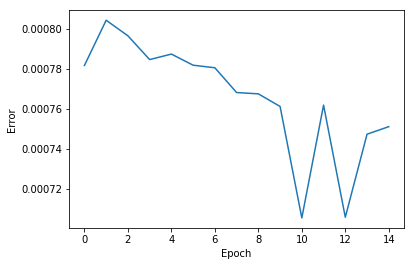

In [32]:
# Train RBM with 15 Epochs, with Each Epoch using 10 batches with size 100, After training print out the error by epoch
epochs = 15
batchsize = 100
errors = []
for i in range(epochs):
    for start, end in zip(range(0, len(trX), batchsize), range(batchsize, len(trX), batchsize)):
        batch = trX[start:end]
        cur_w = sess.run(update_w, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_hb = sess.run(update_hb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_hb
    errors.append(sess.run(err_sum, feed_dict={v0: trX, W: cur_w, vb: cur_vb, hb: cur_hb}))
    print(errors[-1])

plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

In [33]:
# Select the example User
inputUser = [trX[1]]

In [34]:
# Feeding in the User and Reconstructing the input
hh0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
feed = sess.run(hh0, feed_dict={v0: inputUser, W: prv_w, hb: prv_hb})
recommendation = sess.run(vv1, feed_dict={hh0: feed, W: prv_w, vb: prv_vb})

In [35]:
# List the 20 most recommended items for our mock user by sorting it by their scores given by our model.
recos_for_user = product_data
recos_for_user["Recommendation Score"] = recommendation[0]
recos_for_user.sort_values(["Recommendation Score"], ascending=False).head(20)

,asin,description,price,categories,title,brand,prod_index,Recommendation Score
15714,B000B9RI14,Xbox LIVE is the online service for your Xbox ...,24.990000,"[[Electronics, Computers & Accessories], [Gift...",NaN,NaN,15714,0.013522
43126,B008FHL56S,Shipping by Fedex Express&#x3002;The 320GB Har...,45.060001,"[[Video Games, Xbox 360, Accessories, Memory]]",320GB HDD Compatible with Xbox 360 Slim,Generic,43126,0.013407
50160,B00HVBPRUO,,99.989998,"[[Video Games, PlayStation 4, Accessories, Hea...",NaN,NaN,50160,0.010498
44274,B009KS4XRO,NaN,NaN,"[[Apps for Android, Games], [Video Games, Fire...",NaN,NaN,44274,0.009216
45933,B00BGA9WK2,,28.120001,"[[Electronics, Television & Video, Blu-ray Pla...",NaN,NaN,45933,0.008478
48536,B00FAX6XQC,NaN,NaN,"[[Apps for Android, Games], [Video Games, Fire...",NaN,NaN,48536,0.008035
45421,B00AW3FDIO,NaN,NaN,"[[Apps for Android, Games], [Video Games, Fire...",NaN,NaN,45421,0.007839
45151,B00AIUUXHC,NaN,NaN,"[[Apps for Android, Games], [Video Games, Fire...",NaN,NaN,45151,0.007087
23879,B0015AARJI,The Dualshock 3 wireless controller for the Pl...,54.990002,"[[Electronics, Accessories & Supplies, Audio &...",NaN,NaN,23879,0.006974
20599,B000P46NMA,Assassin?s Creedis the next-gen game developed...,19.990000,[[Video Games]],NaN,NaN,20599,0.006881


In [36]:
""" Recommend User item he has not watched yet """

# Find the mock user's UserID from the data
data_combined.iloc[50]  # Result you get is UserID 191

reviewerID    A25M791P4YG471
asin              0545076412
overall                    1
prod_index                19
Name: 50, dtype: object

In [39]:
# Find all items the mock user has rated before
rated_item_for_user = data_combined[data_combined['reviewerID'] == 'A25M791P4YG471']
rated_item_for_user.head()

,reviewerID,asin,overall,prod_index
50,A25M791P4YG471,0545076412,1.0,19


In [40]:
""" Merge all items that our mock users has watched with predicted scores based on his historical data: """

# Merging scored items with rated items by ID
merge_watched_recommended = recos_for_user.merge(rated_item_for_user, on='asin', how='outer')
merge_watched_recommended.head()

,asin,description,price,categories,title,brand,prod_index_x,Recommendation Score,reviewerID,overall,prod_index_y
0,0078764343,Brand new sealed!,37.98,"[[Video Games, Xbox 360, Games]]",NaN,NaN,0,0.000003,NaN,NaN,NaN
1,043933702X,In Stock NOW. Eligible for FREE Super Saving ...,23.50,"[[Video Games, PC, Games]]",NaN,NaN,1,0.000006,NaN,NaN,NaN
2,0439339987,Grandma Groupers kelp seeds are missing and wi...,8.95,"[[Video Games, PC, Games]]",NaN,NaN,2,0.000002,NaN,NaN,NaN
3,0439342260,This software is BRAND NEW. Packaging may diff...,NaN,"[[Video Games, PC, Games]]",NaN,NaN,3,0.000010,NaN,NaN,NaN
4,0439339960,a scholastic clubs fairs cd rom game,NaN,"[[Video Games, PC, Games]]",NaN,NaN,4,0.000040,NaN,NaN,NaN


In [42]:
# Dropping unnecessary columns
merge_watched_recommended = merge_watched_recommended.drop('prod_index_y', axis=1).drop('reviewerID', axis=1)

In [43]:
# Sort and take a look at first 20 rows
merge_watched_recommended.sort_values(['Recommendation Score'], ascending=False).head(20)

,asin,description,price,categories,title,brand,prod_index_x,Recommendation Score,overall
15714,B000B9RI14,Xbox LIVE is the online service for your Xbox ...,24.990000,"[[Electronics, Computers & Accessories], [Gift...",NaN,NaN,15714,0.013522,NaN
43126,B008FHL56S,Shipping by Fedex Express&#x3002;The 320GB Har...,45.060001,"[[Video Games, Xbox 360, Accessories, Memory]]",320GB HDD Compatible with Xbox 360 Slim,Generic,43126,0.013407,NaN
50160,B00HVBPRUO,,99.989998,"[[Video Games, PlayStation 4, Accessories, Hea...",NaN,NaN,50160,0.010498,NaN
44274,B009KS4XRO,NaN,NaN,"[[Apps for Android, Games], [Video Games, Fire...",NaN,NaN,44274,0.009216,NaN
45933,B00BGA9WK2,,28.120001,"[[Electronics, Television & Video, Blu-ray Pla...",NaN,NaN,45933,0.008478,NaN
48536,B00FAX6XQC,NaN,NaN,"[[Apps for Android, Games], [Video Games, Fire...",NaN,NaN,48536,0.008035,NaN
45421,B00AW3FDIO,NaN,NaN,"[[Apps for Android, Games], [Video Games, Fire...",NaN,NaN,45421,0.007839,NaN
45151,B00AIUUXHC,NaN,NaN,"[[Apps for Android, Games], [Video Games, Fire...",NaN,NaN,45151,0.007087,NaN
23879,B0015AARJI,The Dualshock 3 wireless controller for the Pl...,54.990002,"[[Electronics, Accessories & Supplies, Audio &...",NaN,NaN,23879,0.006974,NaN
20599,B000P46NMA,Assassin?s Creedis the next-gen game developed...,19.990000,[[Video Games]],NaN,NaN,20599,0.006881,NaN
